In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

crimes = pd.read_csv('../crimes.csv', index_col='Date Reported', parse_dates=True)
violations = pd.read_csv('finalviolations.csv', sep=',', index_col=0)

In [2]:
list(crimes.columns)

['RMS CDW ID',
 'General Offense Number',
 'Offense Code',
 'Offense Code Extension',
 'Offense Type',
 'Summary Offense Code',
 'Summarized Offense Description',
 'Occurred Date or Date Range Start',
 'Occurred Date Range End',
 'Hundred Block Location',
 'District/Sector',
 'Zone/Beat',
 'Census Tract 2000',
 'Longitude',
 'Latitude',
 'Location',
 'Month',
 'Year']

In [3]:
crimes = crimes[['Summarized Offense Description','District/Sector', 'Zone/Beat', 'Latitude', 'Longitude']].dropna()
crimes = crimes[crimes['Latitude'] != 0.0]

In [4]:
crimes['District/Sector'].value_counts()

M     49262
K     45964
D     44781
U     44312
E     43359
B     40811
N     38837
J     36998
R     36209
Q     35953
L     35891
S     32155
W     31379
C     29715
F     29114
G     28112
O     22506
99     1197
H         2
dtype: int64

In [5]:
crimes['Summarized Offense Description'].str.capitalize().value_counts()

Car prowl                           113755
Other property                       76345
Burglary                             66231
Property damage                      47299
Vehicle theft                        45338
Fraud                                35032
Assault                              34662
Warrant arrest                       32415
Threats                              21689
Disturbance                          20597
Stolen property                      19915
Shoplifting                          19906
Narcotics                            15117
Robbery                              13640
Bike theft                           10183
Trespass                              8245
Burglary-secure parking-res           5629
Traffic                               4178
Weapon                                3267
Lost property                         3152
Prostitution                          3026
Dispute                               2862
Mail theft                            2823
Pickpocket 

count       95.000000
mean      6595.336842
std       2801.083208
min          1.000000
25%       4408.000000
50%       5769.000000
75%       9075.000000
max      11994.000000
dtype: float64

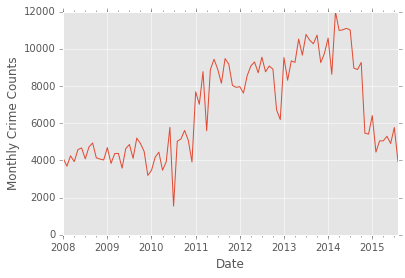

In [6]:
crime_counts = crimes.index.value_counts().resample('M', how='sum')
crime_counts['2008-01-01':].plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')

crime_counts.describe()

In [7]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [8]:
cases = pd.DataFrame({'Crime Counts': pd.Series(crime_counts, index=crime_counts.index),
                     'Daylight Hours': pd.Series(crime_counts.index.map(hours_of_daylight), index=crime_counts.index),
                     'Weekday': pd.Series(crime_counts.index.dayofweek, index=crime_counts.index)})
cases = cases.fillna(0)
cases = cases['2008-01-01':]

In [9]:
from sklearn.linear_model import LinearRegression

x = cases[['Daylight Hours','Weekday']]
y = cases['Crime Counts']
fit = LinearRegression().fit(x,y)

cases['Trend1'] = fit.predict(x)
cases['Detrended1'] = cases['Crime Counts'] - cases['Trend1'] + cases['Trend1'].mean()

Detrended1      2554.208306
Crime Counts    2573.791152
dtype: float64

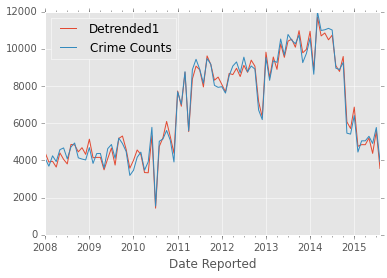

In [10]:
cases[['Detrended1','Crime Counts']].plot()
cases[['Detrended1','Crime Counts']].std()

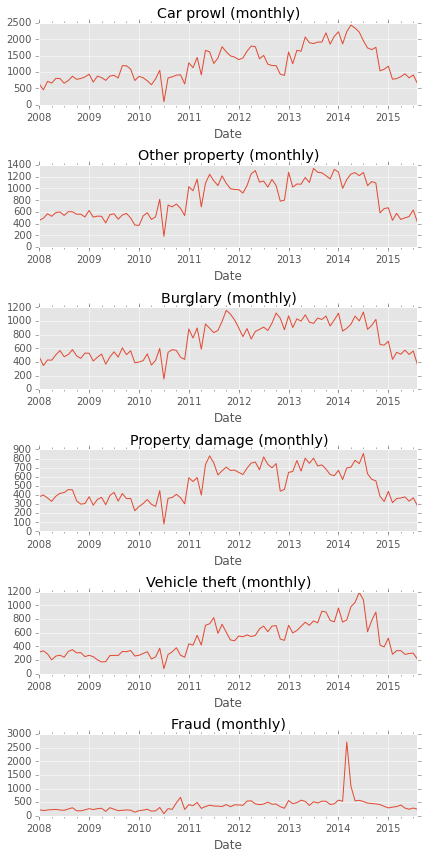

In [11]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(6,12))

descriptions = crimes['Summarized Offense Description'].str.capitalize()
offenses = [descriptions.value_counts().index[i] for i in range(6)]

for i in range(6):
    descriptions[descriptions == offenses[i]].index.value_counts().resample('M', how='sum').plot(ax=axes[i])
    axes[i].set_title(str(offenses[i]) + ' (monthly)')
    axes[i].set_xlabel('Date')
fig.tight_layout()

In [12]:
dist = crimes['District/Sector']
distN = crimes[(dist == 'B') | (dist == 'N') | (dist == 'L') | (dist == 'J') | (dist == 'U')]
distS = crimes[(dist == 'O') | (dist == 'R') | (dist == 'S')]
distE = crimes[(dist == 'E') | (dist == 'C') | (dist == 'G')]
distW = crimes[(dist == 'Q') | (dist == 'D') | (dist == 'M') | (dist == 'K')]
distSW = crimes[(dist == 'W') | (dist == 'F')]

In [13]:
dist_list = [distN, distS, distE, distW, distSW]
dist_str = ['North', 'South', 'East', 'West', 'Southwest']
for i in range(5):
    print(dist_str[i])
    print(dist_list[i]['Summarized Offense Description'].value_counts().head(5))
    print('\n')

North
CAR PROWL          35555
BURGLARY           24808
OTHER PROPERTY     24422
VEHICLE THEFT      17356
PROPERTY DAMAGE    15760
dtype: int64


South
CAR PROWL          13651
BURGLARY           13606
OTHER PROPERTY     10254
VEHICLE THEFT       9123
PROPERTY DAMAGE     7521
dtype: int64


East
CAR PROWL          17573
OTHER PROPERTY     12257
BURGLARY            9213
PROPERTY DAMAGE     8197
ASSAULT             6154
dtype: int64


West
CAR PROWL         38034
OTHER PROPERTY    21397
WARRANT ARREST    13854
ASSAULT           13037
BURGLARY          10369
dtype: int64


Southwest
CAR PROWL          8816
BURGLARY           8234
OTHER PROPERTY     7914
VEHICLE THEFT      5867
PROPERTY DAMAGE    5633
dtype: int64




East         0.375454
North        0.378154
South        0.364666
Southwest    0.355740
West         0.381272
dtype: float64

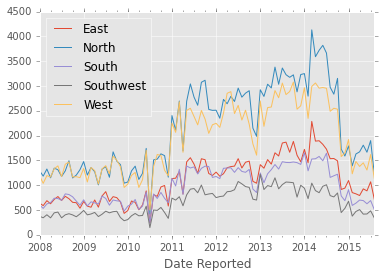

In [73]:
dist_tot = pd.DataFrame({'North': distN.index.value_counts(), 'South': distS.index.value_counts(),
                         'East': distE.index.value_counts(), 'West': distW.index.value_counts(),
                         'Southwest': distSW.index.value_counts()})

dist_tot['2008-01-01':].resample('M', how='sum').plot()
cases['South Counts'] = dist_tot['South'].index.value_counts().resample('M', how='sum')
dist_tot['2008-01-01':].std() / dist_tot['2008-01-01':].mean()

In [76]:
cases['Month Count'] = np.arange(len(cases))

headers = ['Daylight Hours', 'Weekday', 'South Counts', 'Month Count']

In [77]:
fit = LinearRegression().fit(cases[headers], cases['Crime Counts'])

cases['Trend3'] = fit.predict(cases[headers])
cases['Detrended3'] = cases['Crime Counts'] - cases['Trend3'] + cases['Trend3'].mean()

Crime Counts    2573.791152
Detrended3      1558.924599
dtype: float64

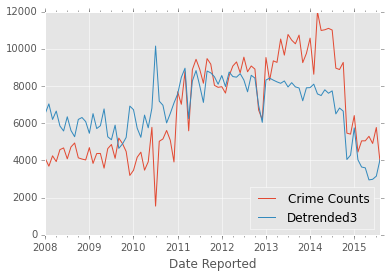

In [80]:
cases[['Crime Counts','Detrended3']].plot()
cases[['Crime Counts','Detrended3']].std()

In [15]:
from bokeh.plotting import figure, output_file, show

# prepare some data
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]

# output to static HTML file
output_file("lines.html", title="line plot example")

# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# add a line renderer with legend and line thickness
p.line(x, y, legend="Temp.", line_width=2)

# show the results
show(p)

In [ ]:
import bokeh.plotting as bk

In [ ]:
bk.output_notebook()